## Clase y métodos. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
f = "../data/002_process/esolmet18_completo.parquet"
lectura_datos = pd.read_parquet(f)
lectura_datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51307 entries, 2017-11-01 00:00:00 to 2018-11-01 23:50:00
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   I_global          51307 non-null  float64
 1   I_difusa          51307 non-null  float64
 2   I_directa         51306 non-null  float64
 3   wind_speed        51307 non-null  float64
 4   temp_exterior     51307 non-null  float64
 5   humedad_relativa  51307 non-null  float64
 6   presion_atm       51307 non-null  float64
dtypes: float64(7)
memory usage: 3.1 MB


In [3]:
class analisis:
    # Self: funciona como una referencia explícita que utilizaremos en los demás métodos. Contiene todos los atributos.
    def __init__(self, filepath: pd.DataFrame, nombres_nuevos :str = None) -> None:
        """
        Recibe el dataframe y un diccionario que contenga los nuevos nombres para renombrar
        las columnas.
        """      
        self.data = pd.read_parquet(filepath)
        if nombres_nuevos != None:
            self.data.rename(columns= nombres_nuevos, inplace=True)
        print(f"Numero de datos cargados: {len(self.data)}")
        
    @property 
    def columnas(self):
        return self.data.columns
        
    @property 
    def datos_inicio(self):  ##primera columna
        return self.data.iloc[0]
    @property
    def inicio_fecha(self):  #fecha
        return self.data.index[0]
    @property 
    def final_data(self): # ultimos datos
        return self.data.iloc[-1]
    @property
    def fin_fecha(self):  
        return self.data.index[-1]
        
    def grafica_mensual(self, columna: str , n:float = 1, vmax : bool = False, vmin : bool = False) -> None:
        #Falta tipado de funciones
        """
        Grafica promedios mensuales teniendo en cuenta la desviación estándar
        y opcionalmente los valores minimos y máximos. 
        Argumentos: (
        columna: columna del dataframe
        n: aplica n- veces la desviación estándar.
        vmax: True para obtener los valores máximos visibles en la gráfica, default = False
        vmin: True para obtener valores minimos en la gráfica, default = False
        )     
        """
        datos_c = self.data[columna]
        promedio = datos_c.resample("1MS").mean()
        #MS es para que aparezcan al inicio de mes y ME para final
        desv = n*datos_c.resample("1MS").std()     
        dmax = datos_c.resample("1MS").max()
        dmin = datos_c.resample("1MS").min()   
        
        fig, ax = plt.subplots(figsize=(12,4))

        ax.plot(datos_c, color= "pink", alpha=0.3)
        ax.plot(promedio,"mo-",label = columna,  alpha=0.4)
        ax.fill_between(promedio.index, promedio - desv, promedio + desv, alpha=0.2, color="gray", label= "+- desviación estándar")
        #ax.plot(desv,"g.",label = "desviación estándar", alpha=0.3)
        if vmax==True:
            ax.plot(dmax,"b.",label = "Max", alpha = 0.2)
        if vmin == True: 
            ax.plot(dmin,"k.",label = "Min", alpha= 0.2)
        
        ax.set_xlabel("Meses.")
        ax.set_ylabel(f" {columna} ")
        
        ax.set_title(f"Valores mensuales de {columna} desde noviembre 2017- noviembre 2018 ")
        ax.legend()
        plt.show()
        
    def intervalo_dia(self, columna: str , regresa_df : pd.DataFrame = False) -> pd.DataFrame:
        """
        Grafica en un intervalo de un dia, una linea de cada dia perteneciente a la serie temporal de la columna seleccionada.
        Regresa el dataframe de esa columna graficada.
        argumentos: (
        columna: columna del dataframe.
        regresa_df =  True para que regrese el dataframe utilizado, default = False
        )
        """
        datos_c = self.data[columna]
        grupo_dias = datos_c.groupby(by= [datos_c.index.strftime("%Y-%m-%d")])
      
        fig, ax= plt.subplots(figsize=(12,4))

        for grupo in grupo_dias:
            dia=grupo[1]   
            ejex= dia.index.strftime("%H: %M")
            ax.plot (ejex, dia.values, color= "gray", alpha=0.3, linewidth=0.3)

        ax.set_xlabel("Tiempo [h].")
        plt.xticks(plt.xticks()[0][0::12])
        ax.set_ylabel(columna)
        ax.set_xlim(0,144)
        
        ax.set_title(f"Valores de la columna {columna} durante un año (noviembre 2017 a noviembre 2018).")
        plt.show()
        
        if regresa_df == True:
            datos_c = datos_c.to_frame()
            return datos_c
         #if regresa_df:
          #  return to_frame()

    def mapa_color(self, columna : str = "To", regresa_df : pd.DataFrame = False ) -> pd.DataFrame:
        """
        Realiza un mapa de color de la columna elegida y regresa el dataframe de la columna. 
        argumentos: (
        columna: columna elegida, default "To". 
        regresa_df = True para que regrese el dataframe utilizado, default = False.
        )
        """
        
        datos_c = self.data[columna]
        datos_freq = datos_c.asfreq("1h")
       
        # Saca los datos promedios mensuales fecha en meses, y luego las horas
        datos_freq.groupby(by = [datos_freq.index.month,datos_freq.index.hour]).mean()
        # Se genera una matriz, separa la dependencia de meses y horas. Y aplicamos la transpuesta para tener la matriz deseada.
        datos_freq.groupby(by=[datos_freq.index.month, datos_freq.index.hour]).mean().unstack().T
        mapa = datos_freq.groupby(by=[datos_freq.index.month,datos_freq.index.hour]).mean().unstack().T
        #Sacar el minimo y maximo de cada columna:
        maximo_c = datos_c.describe().loc["max"]
        min_c = datos_c.describe().loc["min"]        
        #Figura
        fig, ax =plt.subplots(figsize=(12,4))

        #im = ax.imshow(mapa, aspect=0.2,cmap="jet", vmin= 0, vmax = 50)
        im = ax.imshow(mapa, aspect=0.2,cmap="jet")
        #vmax y vmin para definir los maximo s y minimos y la asignacion del color 

        cbar=ax.figure.colorbar(im, ax=ax )
        ax.set_ylabel("Horas", )
        ax.set_xlabel ("Meses")
        #ax.set_xlim(0,12)
        
        ax.set_title(f"Mapa de calor de la columna {columna} durante un año (noviembre 2017 a noviembre2018).")
        plt.show()
        
        if regresa_df == True:    
            datos_c = datos_c.to_frame()
            return datos_c
            
    def energia(self,  inicio : str = "2017-11-01"  , fin : str = "2018-11-01", regresa_df : pd.DataFrame = False) -> pd.DataFrame:
        """
        -Calcula la energía de cada una de las componentes de la radiación solar para cualquier periodo de tiempo durante
         el periodo de noviembre de 2017 a noviembre de 2018.
        -Regresa una gráfica de barras con los datos correspondientes a cada columna de radiación. 
        -Regresa el dataframe de la energía calculada en kWh/m2.
        
        argumentos: (
        inicio: fecha de inicio xxxx-xx-xx, default= "2017-08-01"
        fin: fecha final del periodo xxxx-xx-xx, default= "2018-08-01"
        regresa_df = True para que regrese el dataframe utilizado, default = False.
        )
        """
        datos = self.data[['Id', 'Ig', 'Idi']]
        periodo = datos[inicio: fin]
        #Para sacar la radiación de cada 10  minutos multiplicamos el dataframe x 1/6 para hacerlo por h. 
        # y multiplico entre 0.001 para poner kW
        #La energia esta en KW/m2
        Energia = (periodo * (1/6))* 0.001 
        
        E_tId = Energia["Id"].sum()
        E_tIg = Energia["Ig"].sum()
        E_tIdi = Energia["Idi"].sum()
       
        ybarra = [E_tId, E_tIg, E_tIdi]
        posiciones= range(len(ybarra))
        #print(ybarra)  
        
        print (f"La energía(kWh/m2) entre {inicio} y {fin} es de: {E_tId: .2f} con la columna de radiación directa [Id]")
        print (f"La energía(kWh/m2) entre {inicio} y {fin} es de: {E_tIg: .2f} con la columna de radiación directa [Ig]")
        print (f"La energía(kWh/m2) entre {inicio} y {fin} es de: {E_tIdi: .2f} con la columna de radiación directa [Idi]")

        fig, ax = plt.subplots(figsize = (12,4))

        nombres = ("Energía Id", "Energía Ig", "Energía Idi")
        plt.barh(posiciones, ybarra, color = "red", alpha = 0.3)
        ax.set_xlabel ("Energia (kWh/m2)")
        ax.set_yticks(posiciones, nombres)
        ax.set_title(f"Energía de las columnas de radiación solar entre {inicio} y {fin}.")
        plt.show()
        
        if regresa_df == True:    
            nombres_nuevos = {'Id': "Energia_Id", 'Ig': "Energia_Ig", 'Idi': "Energia_Idi"}
            Energia.rename(columns = nombres_nuevos, inplace=True)
            return Energia


In [4]:
diccionario_ncolumnas={ "I_directa": "Id", 
                        "I_global": "Ig",  
                        "I_difusa" :"Idi",
                        "temp_exterior":"To",
                        "humedad_relativa" : "rh", 
                        "wind_speed": "ws",
                        "presion_atm": "p",  "viento_dir": "wsd"}
ruta_datos = "../data/002_process/esolmet18_completo.parquet"
datos = analisis(ruta_datos, diccionario_ncolumnas)

Numero de datos cargados: 51307


In [5]:
datos.columnas

Index(['Ig', 'Idi', 'Id', 'ws', 'To', 'rh', 'p'], dtype='object')

In [6]:
datos.inicio_fecha


Timestamp('2017-11-01 00:00:00')

In [7]:
datos.fin_fecha

Timestamp('2018-11-01 23:50:00')

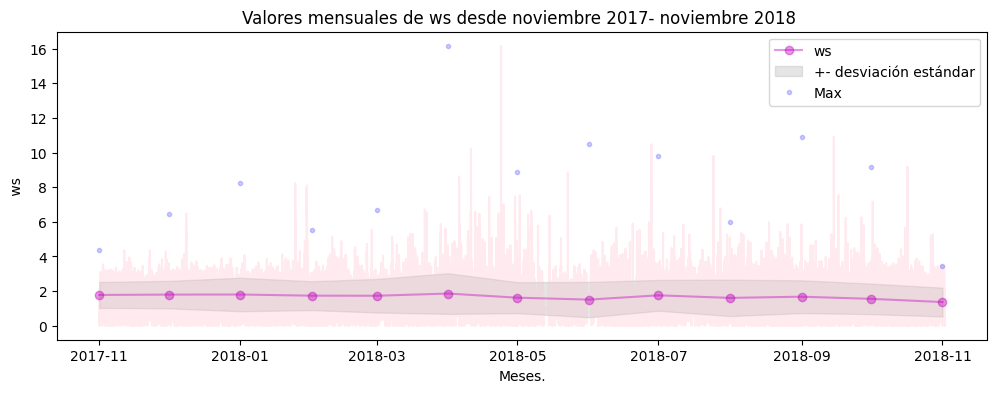

In [8]:
datos.grafica_mensual("ws", n=1, vmax= True)

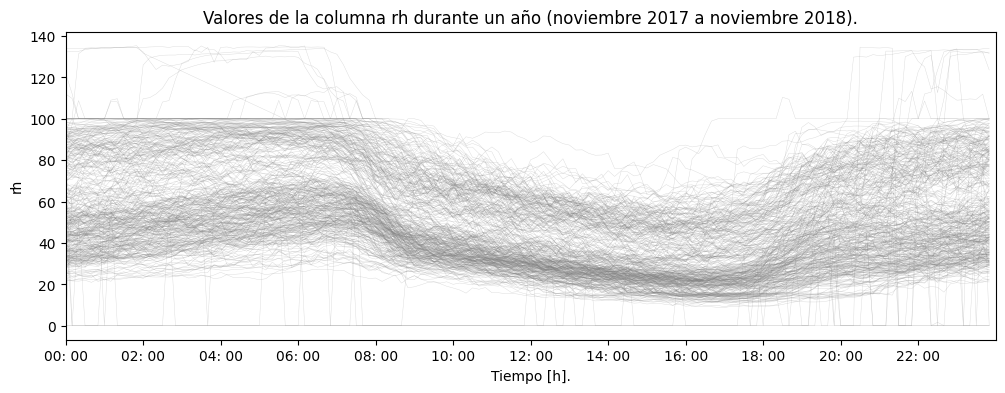

,rh
Fecha,
2017-11-01 00:00:00,66.28
2017-11-01 00:10:00,64.07
2017-11-01 00:20:00,64.13
2017-11-01 00:30:00,67.71
2017-11-01 00:40:00,64.30
...,...
2018-11-01 23:10:00,82.60
2018-11-01 23:20:00,83.60
2018-11-01 23:30:00,83.50


In [9]:
datos.intervalo_dia("rh", True)

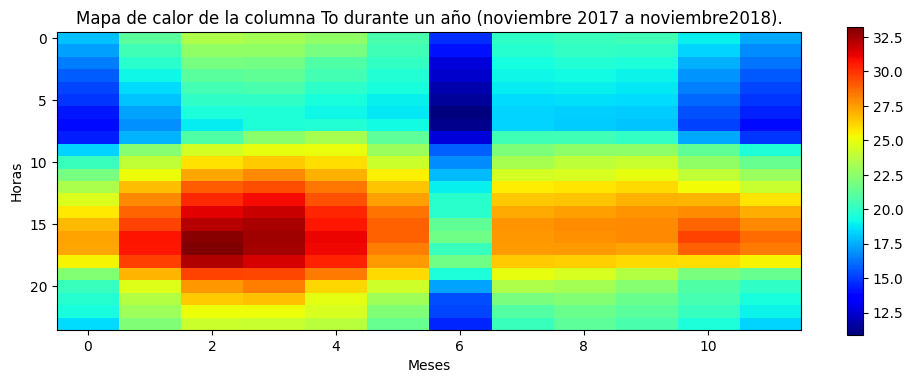

,To
Fecha,
2017-11-01 00:00:00,21.02
2017-11-01 00:10:00,20.99
2017-11-01 00:20:00,21.24
2017-11-01 00:30:00,20.94
2017-11-01 00:40:00,21.01
...,...
2018-11-01 23:10:00,21.28
2018-11-01 23:20:00,21.22
2018-11-01 23:30:00,21.02


In [10]:
datos.mapa_color("To", True)

La energía(kWh/m2) entre 2017-12-03 y 2018-08-16 es de:  1467.47 con la columna de radiación directa [Id]
La energía(kWh/m2) entre 2017-12-03 y 2018-08-16 es de:  1584.87 con la columna de radiación directa [Ig]
La energía(kWh/m2) entre 2017-12-03 y 2018-08-16 es de:  458.98 con la columna de radiación directa [Idi]


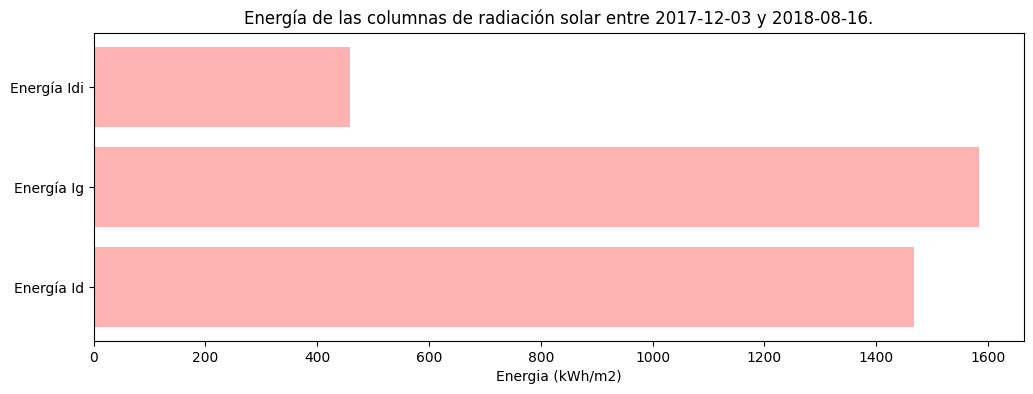

,Energia_Id,Energia_Ig,Energia_Idi
Fecha,,,
2017-12-03 00:00:00,0.000043,0.0,0.0
2017-12-03 00:10:00,0.000032,0.0,0.0
2017-12-03 00:20:00,0.000017,0.0,0.0
2017-12-03 00:30:00,0.000000,0.0,0.0
2017-12-03 00:40:00,0.000008,0.0,0.0
...,...,...,...
2018-08-16 23:10:00,0.000000,0.0,0.0
2018-08-16 23:20:00,0.000000,0.0,0.0
2018-08-16 23:30:00,0.000000,0.0,0.0


In [11]:
datos.energia("2017-12-03", "2018-08-16", True)

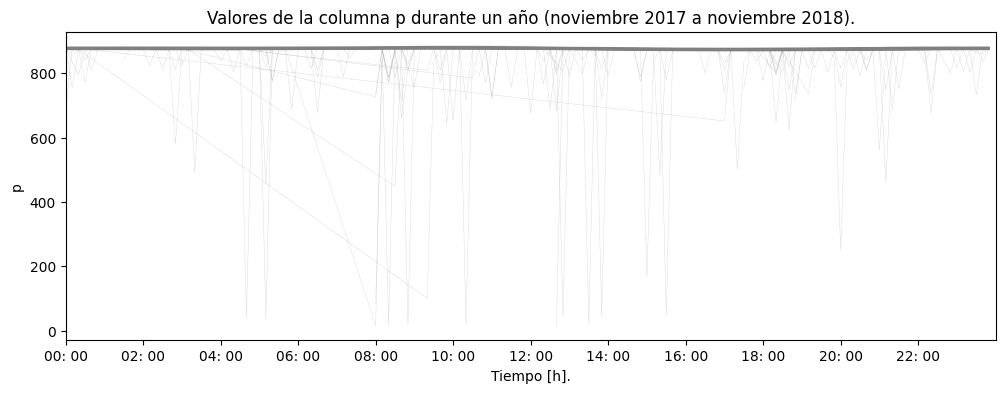

In [12]:
datos.intervalo_dia("p")